##### experiment 5a preprocess

##### This script converts .mp4 or .webm files to .wav files and uses MFA to extract sentence onset time.

### load packages and set up group-level file directories

In [1]:
import pandas as pd
import os
import subprocess
import textgrid
import matplotlib.pyplot as plt
import seaborn as sns
import whisper
from glob import glob
import warnings
warnings.filterwarnings('ignore')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import zipfile
import wave
import numpy as np

data_dir = '/Users/yiwei403/Documents/SONA_data/Exp5/'

### set up subject-level file directories

In [2]:
subject_id = 'SP045'
subject_folder = os.path.join(data_dir,subject_id)
subfolder_name = next(os.walk(subject_folder))[1][0]

if subfolder_name == "5a":
    stimuli_df = pd.read_csv(os.path.join(data_dir, "exp5a.csv"))
    label = 'picture'
    wav_label = 'nameaction'

if subfolder_name == "5c":
    stimuli_df = pd.read_csv(os.path.join(data_dir, "exp5c.csv"))
    label = 'repetition'
    wav_label = 'repaction'

wavs_folder = os.makedirs(os.path.join(data_dir,subject_id,subfolder_name,'wavs'), exist_ok=True)
wavs_dir = os.path.join(data_dir,subject_id,subfolder_name,'wavs')
# transcription_file = f"{subject}_transcription.csv"
pcibex_log = f'{subject_id}_Exp5_{subfolder_name}_pcibex_clean.xlsx'
pcibex_log_df = pd.read_excel(os.path.join(subject_folder,subfolder_name,pcibex_log))

row_index = pcibex_log_df[pcibex_log_df['Label']==label].index[0]
unique_id = pcibex_log_df.at[row_index, 'uniqueID']
print(f'participant`s unique id is {unique_id}')

participant`s unique id is 58e5-9108-64e1-c641


### convert .mp4 or .webm files to .wav files

In [3]:
for file in os.listdir(os.path.join(subject_folder,subfolder_name,'raw_audio')):
    if file.endswith(('.mp4', '.webm')):
        file_name = (os.path.splitext(os.path.basename(file))[0])
        # print(file_name)
        subprocess.call(['ffmpeg', '-loglevel', 'error', '-i', f'{subject_folder}/{subfolder_name}/raw_audio/{file}', f'{wavs_dir}/{file_name}.wav'])

print('ffmpeg process done')

ffmpeg process done


### use stimuli file as transcription

In [4]:
# Loop over the stimuli file rows
for index, row in stimuli_df.iterrows():
    
    content = row['label']
    # Define the name of the text file
    txt_file_name = f"{wav_label}_{row['itemcode']}_{unique_id}.txt"
    
    # Define the path to the text file
    txt_file_path = os.path.join(wavs_dir, txt_file_name)
    # Add the key-value pair to the dictionary, where the value is the third column of the current row
    with open(txt_file_path, 'w') as files:
        files.write(content)



### apply MFA to each .txt/.wav file pair and get a .TextGrid file with word onset time for each target word

In [5]:
# Define the command and arguments
command = 'mfa'
args1 = ['server', 'start']
args2 = ['align', '--clean', '--use_postgres', '--overwrite', wavs_dir, 'english_mfa', 'english_mfa', wavs_dir]

# Run the command
subprocess.run([command] + args1)
subprocess.run([command] + args2)

# remove all the .txt files in the folder. 
# subprocess.run(f'rm {wavs_dir}/*.txt', shell=True)

mfa_output_files = os.listdir(wavs_dir)
textgrid_files = [f for f in mfa_output_files if f.endswith('.TextGrid')]

print(f'MFA done! {str(len(textgrid_files))} generated out of 99 stimuli.')


MFA done! 99 generated out of 99 stimuli.


### extract word onset time from each .TextGrid file and generate a .csv file (wordOnsetTime.csv)

In [6]:
# Create an empty DataFrame to store the results
results = pd.DataFrame()

for file in os.listdir(wavs_dir):
    
    # Check if the file is a TextGrid file
    if file.endswith('.TextGrid'):
        
        # Extract the item code from the file name
        file_name = file[:-9]
        item_code = file_name.split('_')[1]  


        if item_code in pcibex_log_df['itemcode'].values:
            # get the df of the current trial
            trial_df = pcibex_log_df[pcibex_log_df['itemcode'] == item_code]

            recording_start_row = trial_df[(trial_df['Parameter'] == 'Recording') & (trial_df['Value'] == 'Start')]
            recording_start_time = recording_start_row['EventTime'].values[0]
            # print(recording_start_time)
         
            target_print_row = trial_df[(trial_df['PennElementName'].isin(['speak_cue','item'])) & (trial_df['Parameter'] == 'Print')]
            target_print_time = target_print_row['EventTime'].values[0]
            # print(target_print_time)
            
            stim_time = int(target_print_time) - int(recording_start_time)

            # Get the transcription of the target word corresponding to the item code
            target_word = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'name'].values[0] 
            verb_freq = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'verb_freq'].values[0] 
            verb_regularity = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'verb_regularity'].values[0]
            ipnp_latency = pcibex_log_df.loc[pcibex_log_df['itemcode'] == item_code, 'ipnp_latency'].values[0]

            new_row = pd.DataFrame({
                    'filename': [file_name],
                    'sub_folder':[subfolder_name],
                    'subject': [subject_id],
                    'itemcode': [item_code],
                    'target_word': [target_word],
                    'verb_freq': [verb_freq],
                    'verb_regularity':[verb_regularity],
                    'ipnp_latency':[ipnp_latency],
                    'stim_time':[stim_time],
                })
            
            # Read the TextGrid file
            textGridFile = textgrid.TextGrid.fromFile(os.path.join(wavs_dir, file))
            
            # Extract the word tier from the TextGrid file, and find the onset time of the target word
            wordTier = textGridFile.tiers[0]
            for interval in wordTier:
                if interval.mark != "":
                    # Create a new row with the item code, target word, file name, and onset time
                    new_row['MFA_word_onset'] = interval.minTime-stim_time/1000
                    break
                else:
                    new_row['MFA_word_onset'] = None
            results = pd.concat([results, new_row], ignore_index=True)
        else:
            print(f'{item_code} not in stimuli_df')


# Save the results to a .csv file
results.to_csv(os.path.join(data_dir,subject_id,subfolder_name,f'{subject_id}_Exp5_{subfolder_name}_adjustedSentenceOnsetTime.csv'), index=False)

### plot individual subject' word onset times by condition 

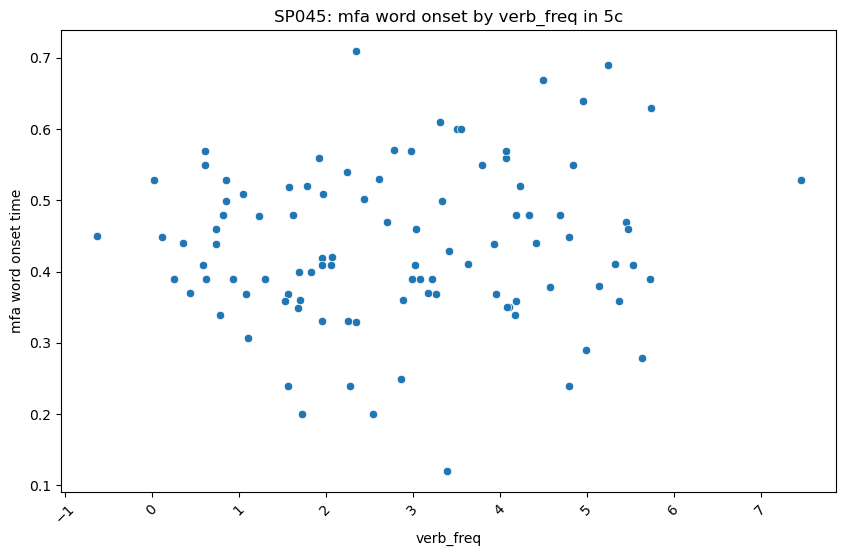

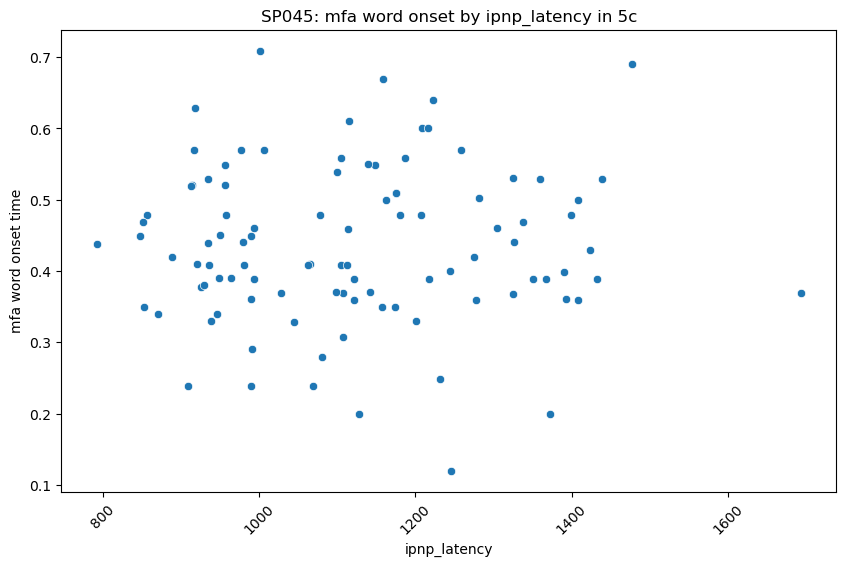

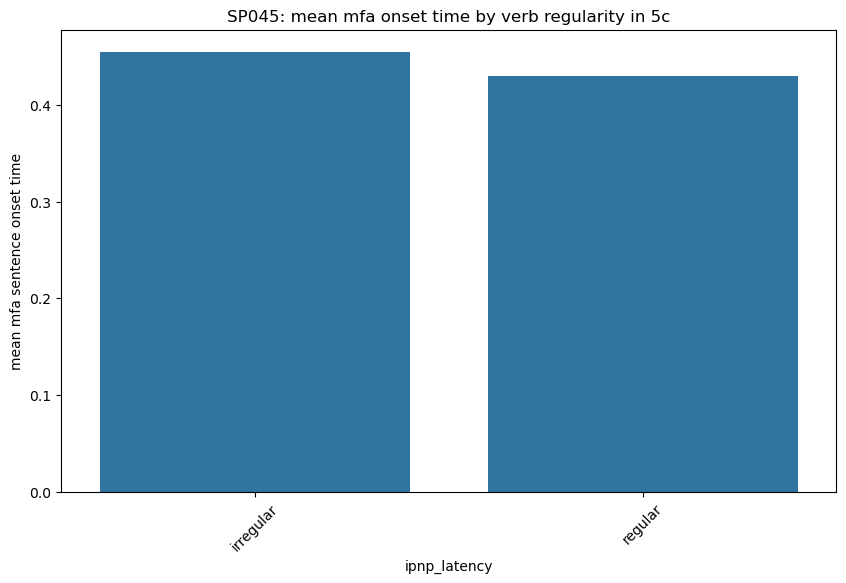

In [7]:
subject_id = subject_id

results = pd.read_csv(os.path.join(data_dir,subject_id,subfolder_name,f'{subject_id}_Exp5_{subfolder_name}_adjustedSentenceOnsetTime.csv'))
results['verb_freq']=np.log(results['verb_freq'])

scatter_conditions = ['verb_freq', 'ipnp_latency']
for condition in scatter_conditions:
    # plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data = results, x = condition, y = 'MFA_word_onset')
    plt.title(f"{subject_id}: mfa word onset by {condition} in {subfolder_name}")
    plt.xlabel(condition)
    plt.ylabel('mfa word onset time')
    plt.xticks(rotation=45)
    plt.show()


mean_mfa_onset_time = results.groupby('verb_regularity').agg({'MFA_word_onset':'mean'}).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='verb_regularity', y='MFA_word_onset', data=mean_mfa_onset_time, errorbar='sd')
plt.title(f"{subject_id}: mean mfa onset time by verb regularity in {subfolder_name}")
plt.xlabel(condition)
plt.ylabel("mean mfa sentence onset time")
# plt.ylim(0.75,1.5)
plt.xticks(rotation=45)
plt.show()


### plot group data

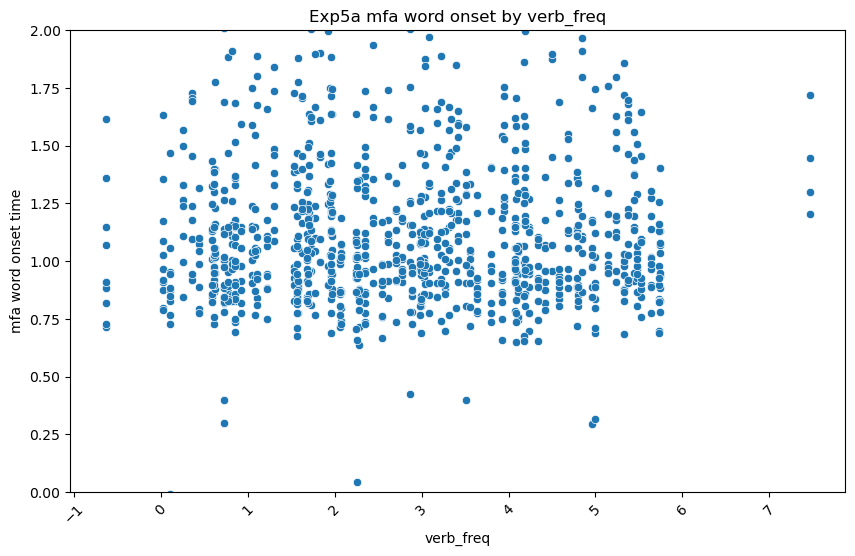

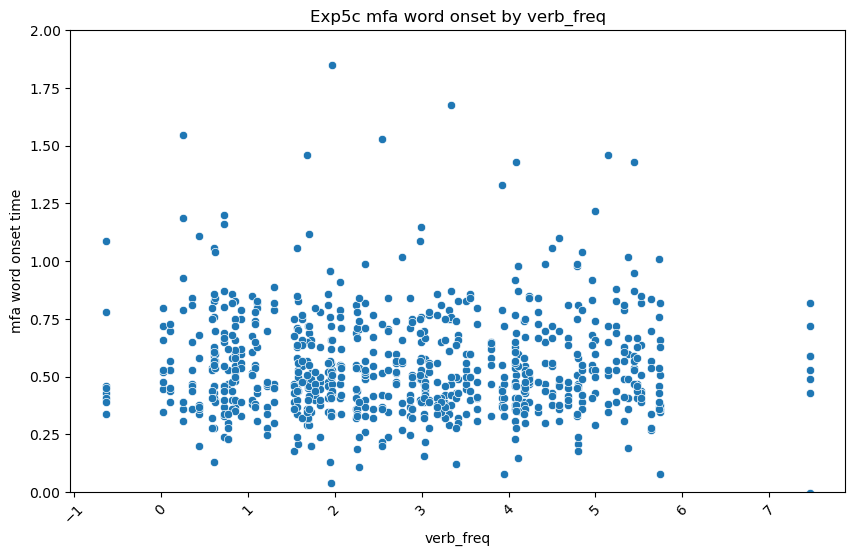

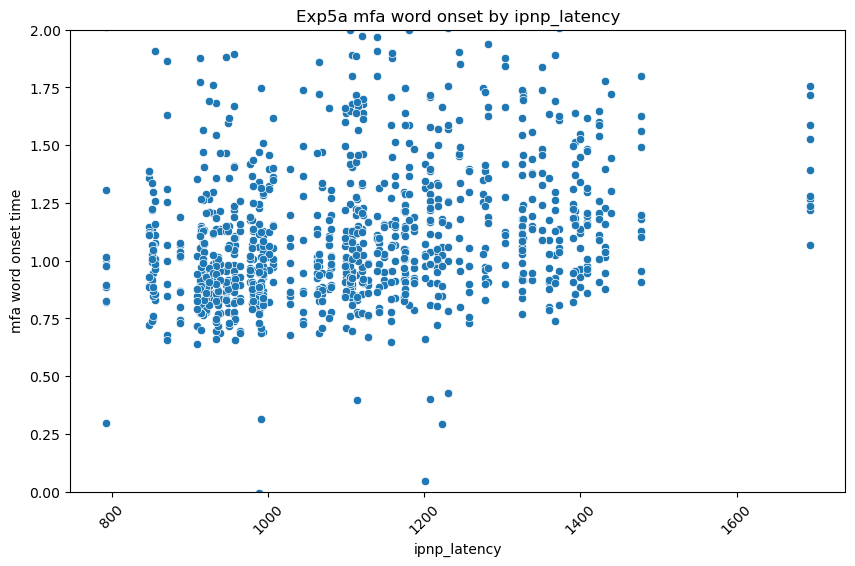

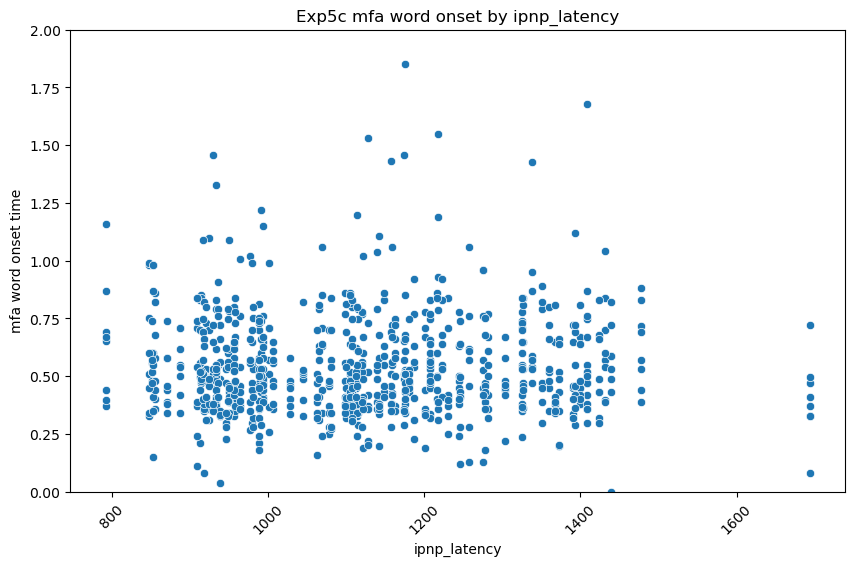

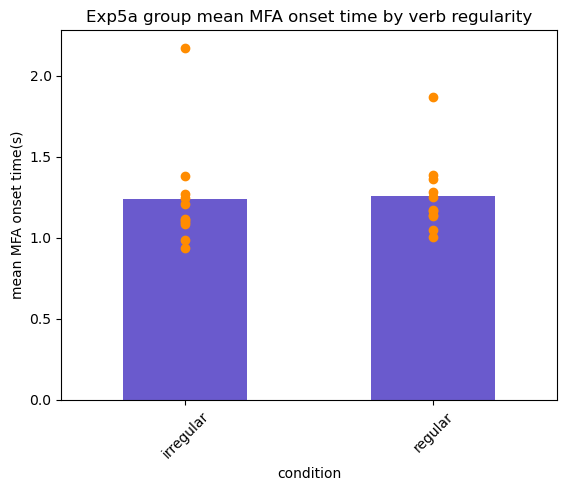

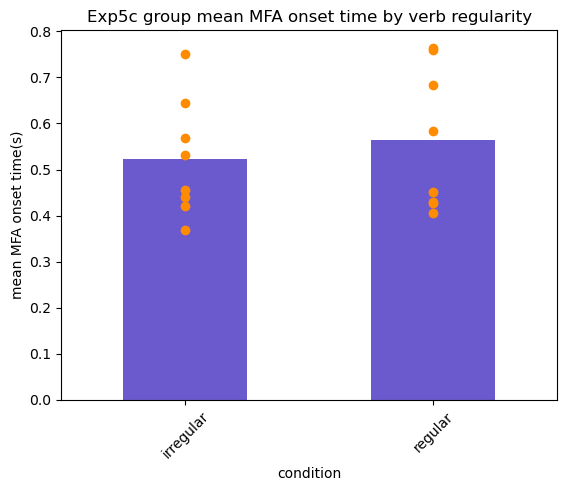

In [9]:
subject_folders = [item for item in os.listdir(data_dir) if item.startswith('SP')]
# print(subject_folders)

group_df = []

for subject_folder in subject_folders:
    # print(subject_folder)
    for subfolder in ['5a','5c']:
        subfolder_path = os.path.join(data_dir, subject_folder, subfolder)
        if os.path.exists(subfolder_path):
            # print(subfolder_path)
            csv_file = glob(os.path.join(subfolder_path, "*_adjustedSentenceOnsetTime.csv"))
            # print(csv_file)
            if csv_file:
                csv_file = csv_file[0]
                # print(csv_file)
                df = pd.read_csv(csv_file)
            group_df.append(df)

all_data = pd.concat(group_df, ignore_index=True)
all_data['verb_freq']=np.log(all_data['verb_freq'])


for condition in scatter_conditions:
    for subfolder in ['5a', '5c']:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data = all_data[all_data['sub_folder'] == subfolder], x = condition, y = 'MFA_word_onset')
        plt.title(f"Exp{subfolder} mfa word onset by {condition}")
        plt.xlabel(condition)
        plt.ylabel('mfa word onset time')
        if subfolder == '5a':
            plt.ylim(0,2)
        elif subfolder == '5c':
            plt.ylim(0,2)
        plt.xticks(rotation=45)
        plt.show()

for subfolder in ['5a', '5c']:
    all_data_subfolder = all_data[all_data['sub_folder'] == subfolder]
    group_average = all_data_subfolder.groupby('verb_regularity')['MFA_word_onset'].mean()
    subject_average = all_data_subfolder.groupby(['subject', 'verb_regularity'])['MFA_word_onset'].mean()

    group_plot = group_average.plot(kind='bar', color = '#6A5ACD')

    for IV in group_average.index:
        # print(IV)
        IV_data = subject_average[subject_average.index.get_level_values('verb_regularity') == IV]
        # print(IV_data)
        group_plot.scatter([IV] * len(IV_data), IV_data.values, color = '#FF8C00')
        # print(IV_data.values)
    
    plt.xlabel('condition')
    plt.ylabel('mean MFA onset time(s)')
    plt.title(f'Exp{subfolder} group mean MFA onset time by verb regularity')
    plt.xticks(rotation=45)
    plt.show() 